In [ ]:
import os
import json
import cv2
import matplotlib.pyplot as plt

# Percorsi dei file
# Dataset paths and JSON mapping
json_files = ["/media/vrlab/Extreme Pro/DataSet/DATA/TUSIMPLE/label_data_0313.json", 
              "/media/vrlab/Extreme Pro/DataSet/DATA/TUSIMPLE/label_data_0531.json", 
              "/media/vrlab/Extreme Pro/DataSet/DATA/TUSIMPLE/label_data_0601.json"]
              
images_path = "/media/vrlab/Extreme Pro/DataSet/DATA/TUSIMPLE/clips/"

# Caricamento dei dati dalle annotazioni JSON
def load_annotations(json_files):
    annotations = []
    for file in json_files:
        with open(file, "r") as f:
            annotations.extend(json.load(f))
    return annotations

# Disegna le corsie su un'immagine
def draw_lanes(image_path, lanes, h_samples):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for lane in lanes:
        points = [(x, y) for x, y in zip(lane, h_samples) if x >= 0]  # Filtra punti validi
        for i in range(len(points) - 1):
            cv2.line(img, points[i], points[i + 1], (255, 0, 0), 2)
    
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Elaborazione delle immagini con annotazioni
annotations = load_annotations(json_files)

for ann in annotations[:5]:  # Visualizziamo solo le prime 5 immagini per test
    image_path = os.path.join(images_path, ann["raw_file"])
    if os.path.exists(image_path):
        print(f"Visualizzando: {image_path}")
        draw_lanes(image_path, ann["lanes"], ann["h_samples"])
    else:
        print(f"Immagine non trovata: {image_path}")


JSONDecodeError: Extra data: line 2 column 1 (char 1219)

In [49]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class LaneDetectionDatasetHighRes(Dataset):
    def __init__(self, data_dir, json_mapping, folders):
        """
        Initialize dataset for lane detection in high resolution.
        
        Args:
            data_dir (str): Path to the dataset.
            json_mapping (dict): Mapping of folders to their respective JSON label files.
            folders (list): Folders containing video clips.
        """
        self.data_dir = data_dir
        self.json_mapping = json_mapping
        self.folders = folders
        self.data = []

        # Parse JSON files and prepare data
        self._prepare_data()

    def _prepare_data(self):
        for folder in self.folders:
            json_file = self.json_mapping[folder]
            json_path = os.path.join(self.data_dir, json_file)

            with open(json_path, 'r') as f:
                for line in f:
                    label = json.loads(line.strip())
                    raw_file = label['raw_file']

                    # Ensure the raw_file corresponds to the current folder
                    if not raw_file.startswith(f"clips/{folder}"):
                        continue

                    # Extract the subfolder and 20th frame path
                    subfolder_path = os.path.join(self.data_dir, os.path.dirname(raw_file))
                    target_frame_path = os.path.join(subfolder_path, "20.jpg")
                    
                    if not os.path.exists(target_frame_path):
                        continue

                    # Collect all 20 frame paths
                    frame_paths = [os.path.join(subfolder_path, f"{i}.jpg") for i in range(1, 21)]
                    if all(os.path.exists(path) for path in frame_paths):
                        self.data.append((frame_paths, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame_paths, label = self.data[idx]

        # Load all 20 frames in their original resolution (720x1280)
        frames = []
        for path in frame_paths:
            img = cv2.imread(path)
            img = img / 255.0  # Normalize to [0, 1]
            frames.append(img)

        frames = np.stack(frames, axis=0)  # Shape: (20, 720, 1280, 3)

        # Generate the binary mask for the 20th frame
        y_threshold = 350
        mask = np.zeros((720, 1280), dtype=np.uint8)  # Risoluzione originale
        lanes = label['lanes'][:2]
        h_samples = label['h_samples']

        # Disegna i cerchi per ogni punto valido
        for lane in lanes:
            points = []  # Lista per salvare i punti validi
            for x, y in zip(lane, h_samples):
                if x != -2 and y > y_threshold:  # Salta i punti non validi
                    cv2.circle(mask, (int(x), int(y)), radius=5, color=1, thickness=-1)
                    points.append((int(x), int(y)))  # Aggiungi il punto alla lista

            if len(points) > 1:  # Se ci sono abbastanza punti per formare una linea
                # Converti i punti in un array numpy
                points = np.array(points)

                # Trova il contorno dei punti
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Unisci i punti del contorno in una singola linea (approssimazione poligonale)
                for contour in contours:
                    if len(contour) > 1:  # Se il contorno è valido
                        epsilon = 5  # Definisci la tolleranza per l'approssimazione
                        approx = cv2.approxPolyDP(contour, epsilon, closed=False)
                        
                        # Disegna la linea approssimata sulla maschera
                        cv2.polylines(mask, [approx], isClosed=False, color=255, thickness=6)

        # Converti in tensore PyTorch
        frames = torch.tensor(frames, dtype=torch.float32).permute(0, 3, 1, 2)  # Shape: (20, 3, 720, 1280)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 720, 1280)

        return frames, mask

In [50]:
# Dataset paths and JSON mapping

data_dir = "/media/vrlab/Extreme Pro/DataSet/DATA/TUSIMPLE"
json_mapping = {
    '0313-1': '/media/vrlab/Extreme Pro/DataSet/DATA/TUSIMPLE/label_data_0313.json',
    '0313-2': '/media/vrlab/Extreme Pro/DataSet/DATA/TUSIMPLE/label_data_0313.json',
    '0531': '/media/vrlab/Extreme Pro/DataSet/DATA/TUSIMPLE/label_data_0531.json',
    '0601': '/media/vrlab/Extreme Pro/DataSet/DATA/TUSIMPLE/label_data_0601.json'
}
train_folders = ['0313-1', '0313-2']
val_folders = ['0531']
test_folders = ['0601']

# Initialize high-resolution datasets
train_dataset_high_res = LaneDetectionDatasetHighRes(data_dir, json_mapping, train_folders)
val_dataset_high_res = LaneDetectionDatasetHighRes(data_dir, json_mapping, val_folders)

# Create data loaders
train_loader_high_res = DataLoader(train_dataset_high_res, batch_size=4, shuffle=True)
val_loader_high_res = DataLoader(val_dataset_high_res, batch_size=4, shuffle=False)

# Check a batch
for frames, masks in train_loader_high_res:
    print("Frames shape:", frames.shape)  # Expected: (Batch, 20, 3, 720, 1280)
    print("Masks shape:", masks.shape)    # Expected: (Batch, 1, 720, 1280)
    break



Frames shape: torch.Size([4, 20, 3, 720, 1280])
Masks shape: torch.Size([4, 1, 720, 1280])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


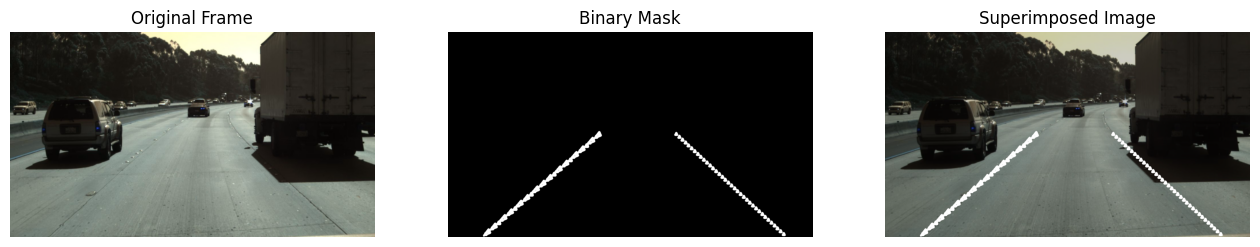

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


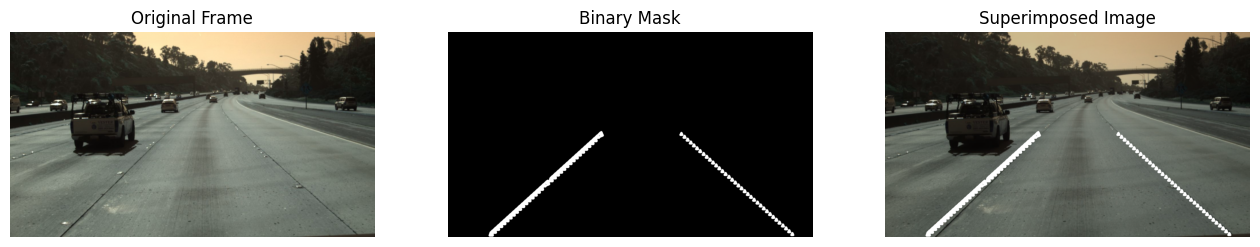

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


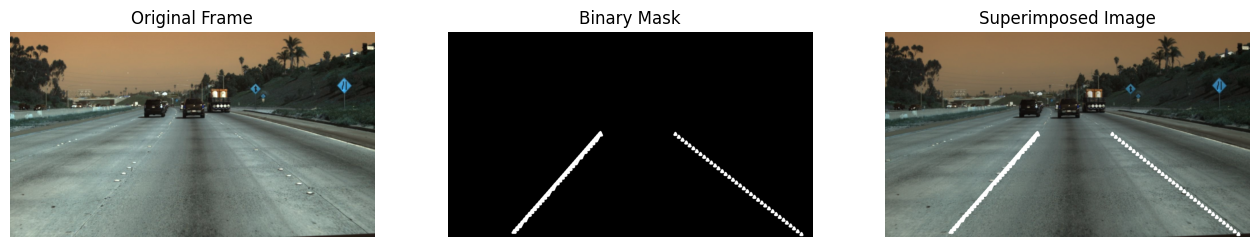

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


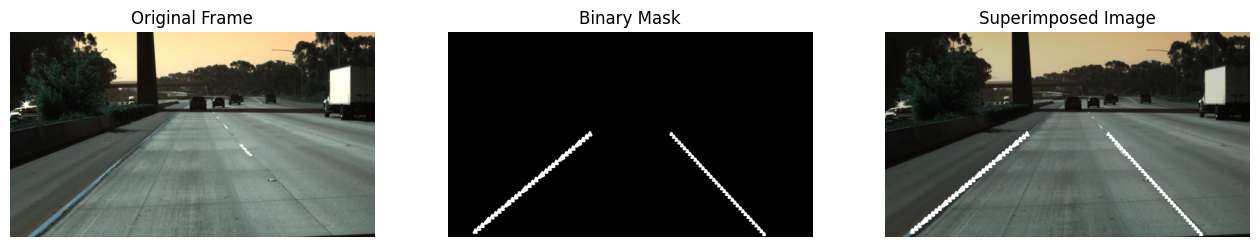

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


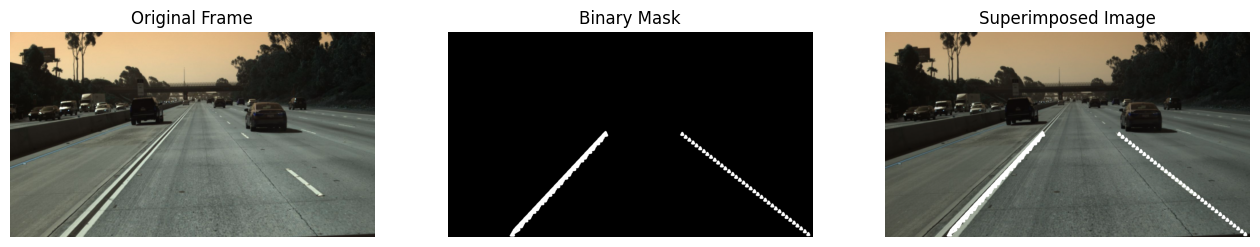

In [51]:
import matplotlib.pyplot as plt

def visualize_dataset_samples_high_res(data_loader, num_samples=5):
    """
    Visualize high-resolution frames, masks, and superimposed images for the dataset.
    
    Args:
        data_loader (DataLoader): PyTorch DataLoader containing frames and masks.
        num_samples (int): Number of samples to visualize.
    """
    count = 0
    for frames, masks in data_loader:
        for i in range(len(frames)):
            if count == num_samples:
                return
            
            # Extract the 20th frame and its corresponding mask
            frame = frames[i, -1].permute(1, 2, 0).cpu().numpy()  # Last frame, shape: (720, 1280, 3)
            mask = masks[i, 0].cpu().numpy()  # Binary mask, shape: (720, 1280)
            #print(mask)

            # Convert mask to RGB
            mask_rgb = np.stack([mask, mask, mask], axis=-1)  # Convert mask to 3 channels

            # Superimpose the mask on the frame
            superimposed = frame * 0.8 + mask_rgb * 0.2  # Blend image and mask

            # Plot the frame, mask, and superimposed result
            plt.figure(figsize=(16, 6))

            plt.subplot(1, 3, 1)
            plt.title("Original Frame")
            plt.imshow(frame)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title("Binary Mask")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title("Superimposed Image")
            plt.imshow(superimposed)
            plt.axis('off')

            plt.show()

            count += 1




visualize_dataset_samples_high_res(train_loader_high_res, num_samples=5)



In [7]:
!pip install pytubefix



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 8.9 MB/s eta 0:00:00


In [5]:
from pytube import YouTube

# URL del video
video_url = "https://www.youtube.com/watch?v=zG7ilwPGGKk"

# Creazione oggetto YouTube
yt = YouTube(video_url)

# Ottenere lo stream con la qualità più alta
video_stream = yt.streams.get_highest_resolution()

# Scaricare il video
print(f"Scaricando: {yt.title} ...")
video_stream.download("/media/vrlab/video/video")

print("Download completato!")


HTTPError: HTTP Error 403: Forbidden

In [ ]:
!pip install yt-dlp

import yt_dlp

video_url = "https://www.youtube.com/watch?v=6OJaquoQNIg"
output_path = "/media/vrlab/video/video"

ydl_opts = {
    'format': 'bestvideo+bestaudio/best',  # Migliore qualità disponibile
    'outtmpl': f"{output_path}/%(title)s.%(ext)s",  # Salva con il titolo originale
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])

print("Download completato!")


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


[youtube] Extracting URL: https://www.youtube.com/watch?v=zG7ilwPGGKk
[youtube] zG7ilwPGGKk: Downloading webpage
[youtube] zG7ilwPGGKk: Downloading ios player API JSON
[youtube] zG7ilwPGGKk: Downloading mweb player API JSON
[youtube] zG7ilwPGGKk: Downloading player e7567ecf


         player = https://www.youtube.com/s/player/e7567ecf/player_ias.vflset/en_US/base.js
         n = P0FMwgwZR7ByXdTyA ; player = https://www.youtube.com/s/player/e7567ecf/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/e7567ecf/player_ias.vflset/en_US/base.js
         n = MwFvmmmzO4JOh1CH5 ; player = https://www.youtube.com/s/player/e7567ecf/player_ias.vflset/en_US/base.js


[youtube] zG7ilwPGGKk: Downloading m3u8 information
[info] zG7ilwPGGKk: Downloading 1 format(s): 271+251
[download] Destination: /media/vrlab/video/video/Steady Night Drive in the Italian Autostrada A22 somewhere between Egna Ora, Termeno and Trento..f271.webm
[download] 100% of  326.32MiB in 00:00:26 at 12.14MiB/s    
[download] Destination: /media/vrlab/video/video/Steady Night Drive in the Italian Autostrada A22 somewhere between Egna Ora, Termeno and Trento..f251.webm
[download] 100% of   21.11MiB in 00:00:06 at 3.32MiB/s     
[Merger] Merging formats into "/media/vrlab/video/video/Steady Night Drive in the Italian Autostrada A22 somewhere between Egna Ora, Termeno and Trento..webm"
Deleting original file /media/vrlab/video/video/Steady Night Drive in the Italian Autostrada A22 somewhere between Egna Ora, Termeno and Trento..f251.webm (pass -k to keep)
Deleting original file /media/vrlab/video/video/Steady Night Drive in the Italian Autostrada A22 somewhere between Egna Ora, Termen

In [12]:


import yt_dlp
import subprocess

video_url = "https://www.youtube.com/watch?v=Z1_xHH6Emq0"
output_path = "/media/vrlab/video/video"
temp_file = f"{output_path}/temp_video_pioggia.mp4"
output_file = f"{output_path}/video_tagliato_pioggia.mp4"

# Scarica il video con yt_dlp
ydl_opts = {
    'format': 'bestvideo+bestaudio/best',
    'outtmpl': temp_file,
    'merge_output_format': 'mp4',  # Assicura che sia in MP4
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])

# Taglia e ridimensiona con ffmpeg
ffmpeg_cmd = [
    "ffmpeg", "-i", temp_file,  # Input video
    "-vf", "scale=2224:1080",  # Ridimensiona a 2224x1080
    "-ss", "00:21:00", "-to", "00:40:00",  # Taglia il video
    "-c:v", "libx264", "-preset", "fast", "-crf", "23",  # Ottimizza la compressione
    "-c:a", "aac", "-b:a", "192k",  # Mantiene l'audio
    output_file
]

subprocess.run(ffmpeg_cmd)

print(f"Download, taglio e ridimensionamento completati! Video salvato in: {output_file}")



Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


[youtube] Extracting URL: https://www.youtube.com/watch?v=Z1_xHH6Emq0
[youtube] Z1_xHH6Emq0: Downloading webpage
[youtube] Z1_xHH6Emq0: Downloading ios player API JSON
[youtube] Z1_xHH6Emq0: Downloading mweb player API JSON
[youtube] Z1_xHH6Emq0: Downloading player c8dbda2a


         player = https://www.youtube.com/s/player/c8dbda2a/player_ias.vflset/en_US/base.js
         n = XfhNKIeqld1uOUh ; player = https://www.youtube.com/s/player/c8dbda2a/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/c8dbda2a/player_ias.vflset/en_US/base.js
         n = 40tjcR56tKgQx71 ; player = https://www.youtube.com/s/player/c8dbda2a/player_ias.vflset/en_US/base.js


[youtube] Z1_xHH6Emq0: Downloading m3u8 information
[info] Z1_xHH6Emq0: Downloading 1 format(s): 315+251
[download] Destination: /media/vrlab/video/video/temp_video_pioggia.f315.webm
[download] 100% of    7.45GiB in 00:02:50 at 44.78MiB/s     
[download] Destination: /media/vrlab/video/video/temp_video_pioggia.f251.webm
[download] 100% of  147.35MiB in 00:00:03 at 44.55MiB/s    
[Merger] Merging formats into "/media/vrlab/video/video/temp_video_pioggia.mp4"
Deleting original file /media/vrlab/video/video/temp_video_pioggia.f315.webm (pass -k to keep)
Deleting original file /media/vrlab/video/video/temp_video_pioggia.f251.webm (pass -k to keep)
Download, taglio e ridimensionamento completati! Video salvato in: /media/vrlab/video/video/video_tagliato_pioggia.mp4


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/vrlab/anaconda3/envs/Tesi --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
Unrecognized option 'preset'.
Error splitting the argument list: Option not found


Accuratezza media: 0.8021
Deviazione standard: 0.2026


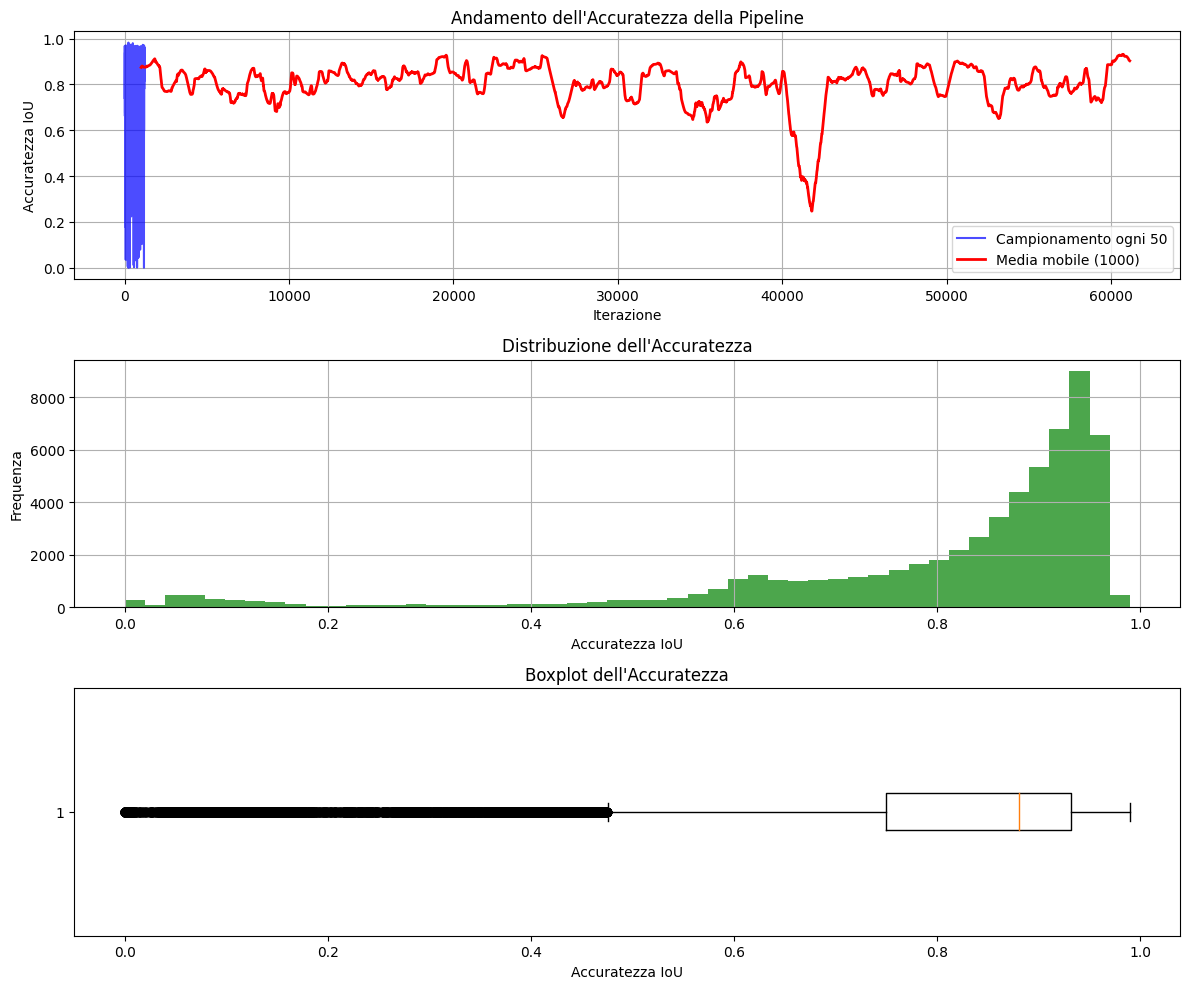

In [7]:
import csv
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy():
    accuracies = []
    
    # Legge il file CSV
    try:
        with open("/home/vrlab/Scaricati/self_driving_vision_and_reconstruction/accuracy_log.csv", "r") as file:
            reader = csv.reader(file)
            for row in reader:
                accuracies.append(float(row[0]))
    except FileNotFoundError:
        print("Nessun dato disponibile per il grafico.")
        return
    
    if not accuracies:
        print("Nessun dato valido per il grafico.")
        return

    # Convertiamo in numpy array per ottimizzare il calcolo
    accuracies = np.array(accuracies)

    # Calcola statistiche
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    # Mostra statistiche principali
    print(f"Accuratezza media: {mean_acc:.4f}")
    print(f"Deviazione standard: {std_acc:.4f}")

    # Campionamento per non avere troppi punti (prendiamo 1 ogni 50)
    sampled_accuracies = accuracies[::50]
    
    # Calcolo della media mobile su finestre di 1000 elementi
    window_size = 1000
    moving_avg = np.convolve(accuracies, np.ones(window_size)/window_size, mode='valid')

    # Creazione del grafico
    fig, axs = plt.subplots(3, 1, figsize=(12, 10))

    # Grafico con campionamento
    axs[0].plot(range(1, len(sampled_accuracies) + 1), sampled_accuracies, linestyle='-', color='b', alpha=0.7, label="Campionamento ogni 50")
    axs[0].plot(range(window_size, window_size + len(moving_avg)), moving_avg, color='r', linewidth=2, label="Media mobile (1000)")
    axs[0].set_xlabel("Iterazione")
    axs[0].set_ylabel("Accuratezza IoU")
    axs[0].set_title("Andamento dell'Accuratezza della Pipeline")
    axs[0].grid(True)
    axs[0].legend()

    # Istogramma della distribuzione dell'accuratezza
    axs[1].hist(accuracies, bins=50, color='g', alpha=0.7)
    axs[1].set_xlabel("Accuratezza IoU")
    axs[1].set_ylabel("Frequenza")
    axs[1].set_title("Distribuzione dell'Accuratezza")
    axs[1].grid(True)

    # Boxplot per visualizzare la variabilità
    axs[2].boxplot(accuracies, vert=False)
    axs[2].set_xlabel("Accuratezza IoU")
    axs[2].set_title("Boxplot dell'Accuratezza")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_accuracy()
